In [660]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [726]:
df_mall = pd.read_csv('Mall_Customers.csv')

# Осмотр данных

In [729]:
df_mall.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [858]:
df_mall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


В данных нет значений типа "null" (пустышки)  

## Проверка на нули 

In [664]:
def zeroes_find(df):
    """
    Функция ищет нули  
    :param df: таблица (DataFrame)
    :return: на выходе мы получаем кол-во нулей в строчках, в которых они есть
    """
    for column_name in df.columns:
        zero_list = df[df[column_name].apply(lambda x: x == 0)]
        if not zero_list.empty:
            print(f"'{column_name}' кол-во строк нулей: {len(zero_list)}")

In [665]:
zeroes_find(df_mall)

В данных нет нулевых значений

## Поищем выбросы в данных 

In [666]:
def box_plot(df):

    """
    Функция рисует графики выбросов по 5 в строчке
    :param df: на вход подается таблица (DataFrame) с выделенными колонками для поиска, если на вход подали колонку таблицы, то она выведется одна
    :return: рисует графики "box_plot"
    """
    if type(df) is type(pd.Series({1: "1"})):
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
        sns.boxplot(x=df, color="purple")
        plt.tight_layout()
        plt.show()
    else:
        list_col = df.columns
        count = 1
        while True:
            if count * 5 > len(list_col):
                small_df = df[list_col[(count - 1) * 5:len(list_col)]]
            else:
                small_df = df[list_col[(count - 1) * 5:count * 5]]

            fig, axes = plt.subplots(nrows=1, ncols=len(small_df.columns), figsize=(10, 5))

            for i, column in enumerate(small_df.columns):
                sns.boxplot(x=small_df[column], ax=axes[i], color="purple")
                axes[i].set_title(column, fontsize=10)

            if count * 5 >= len(list_col):
                break
            count += 1
            plt.tight_layout()
            plt.show()

In [667]:
df_num = df_mall.select_dtypes(exclude=['object'])

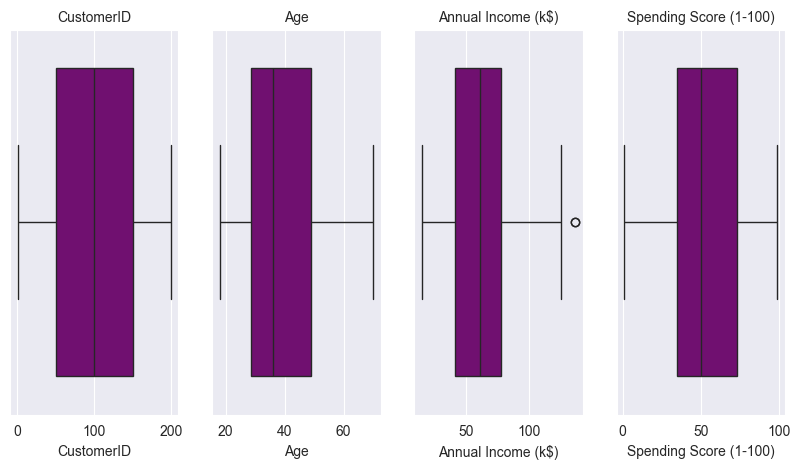

In [668]:
box_plot(df_num)

Выбросы есть только в колонке "Annual Income (k$)", предлагаю посмотреть сколько этих значений 

In [669]:
max_value = df_num["Annual Income (k$)"].max()
print(f"Максимальное значение в колонке '{"Annual Income (k$)"}': {max_value}, количество значений {df_num["Annual Income (k$)"][df_num["Annual Income (k$)"] == max_value].count()}")

Максимальное значение в колонке 'Annual Income (k$)': 137, количество значений 2


Значений довольно прилично, смотря на количество строк в данных, данные нам - оставляем 

Перед кластеризацией удаляю не нужный столбец это номер пользователя. Он идет по возрастанию и не несет нужных данных для разбиения, только то что можно посмотреть как давно пользователь в базе, но не думаю, что "ID" добавлен с этим условием 

In [670]:
df_mall.drop(['CustomerID'], axis=1,inplace=True)

# Кластеризация

## Пред кластеризация 

Начнем с кодирования данных, в нашем случае только пол клиента

In [707]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, normalize

df_cluster = df_mall.copy()
categorical_columns = df_cluster.select_dtypes(include=['object']).columns.tolist()
ordinal_encoder = OrdinalEncoder()
encoded_data = ordinal_encoder.fit_transform(df_cluster[categorical_columns])
df_cluster[categorical_columns] = encoded_data.astype(int)

Далее масштабируем данные и нормализуем 

In [716]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_cluster)
normalize_f = normalize(scaled_features) 
df_iterate = pd.DataFrame(normalize_f, index=df_cluster.index, columns=df_cluster.columns)

## Находим количество кластеров

Было дано в материалах два метода "Локтя" и "Силуэта"

Я слышал, что локти быстро стареют, поэтому будем использовать силуэты)

Для данного деяния, переходим в документацию sklearn, копируем код и доделываем его (делаем список для графика, если понадобится, но его нет и находим лучшее кол-во кластеров)

In [717]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
def get_count_neighbors(df):
    range_n_clusters = [x for x in range(2, 21)]
    max_value_of_silhouette = -1
    num_of_cluster = 0
    cluster_count = []
    
    for n_clusters in range_n_clusters:
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(df)
        silhouette_avg = silhouette_score(df, cluster_labels)
        if max_value_of_silhouette < silhouette_avg:
            max_value_of_silhouette = silhouette_avg
            num_of_cluster = n_clusters
            
        cluster_count.append([n_clusters,silhouette_avg])
    return num_of_cluster, max_value_of_silhouette

Найдем кол-во кластеров по масштабированным данным и нет

In [859]:
num_of_cluster_scale, score_with_scale = get_count_neighbors(df_iterate)
print(f"С масштабируемыми и нормализированными данными кол-во кластеров {num_of_cluster_scale} рейтинг {score_with_scale}")
num_of_cluster_no_scale, score_without_scale = get_count_neighbors(df_cluster)
print(f"Без масштабируемых данных кол-во кластеров {num_of_cluster_no_scale} рейтинг {score_without_scale}")

С масштабируемыми и нормализированными данными кол-во кластеров 13 рейтинг 0.4529037384474444
Без масштабируемых данных кол-во кластеров 6 рейтинг 0.4533101990394104


По итогу будем брать 6 кластеров, 13 это слишком много)

In [718]:
num_of_cluster = 6

## Кластеризация c t-SNE

В задании было сказано перебрать в "t-SNE" параметр "perplexity" 

Написал функцию, которая выводит минимальные и максимальные значения всех колонок в каждом кластере (если есть другой метод посмотреть, как разбил данные визуализатор, то я не знал О.о), для анализа

In [679]:
def min_max_scaler_upgrade(df,name_cluster = None):
    """
    Показывает минимальные и максимальные значения всех колонок в каждом кластере и количество элементов в кластере
    НО ОБЯЗАТЕЛЬНО должна быть колонка "в каком кластере находится строчка" 
    :param df: Таблица (DataFrame) с нашими данными
    :param name_cluster: Имя столбца, где находится номер кластера
    :return: информацию 
    """
    if name_cluster is None:
        name_cluster = "cluster"
        
    indexes = df.groupby(name_cluster)[name_cluster].count().index
    for ind in range(len(df[name_cluster].unique())):
        print(f"В клaстере '{indexes[ind]}' количество {df.groupby(name_cluster)["Annual Income (k$)"].count()[indexes[ind]]}")
        for column in df.columns:
            if column == name_cluster:
                continue
            max_ind = df.groupby(name_cluster)[column].max()
            min_ind = df.groupby(name_cluster)[column].min()
            print(f"'{column}' мин: {min_ind[indexes[ind]]} макс: {max_ind[indexes[ind]]}")
        print("")

Пербирать будем с 15 до 85 с шагом 20, чтобы ухватить неплохой, недалекий друг от друга диапазон

### Кластеризатор KMeans

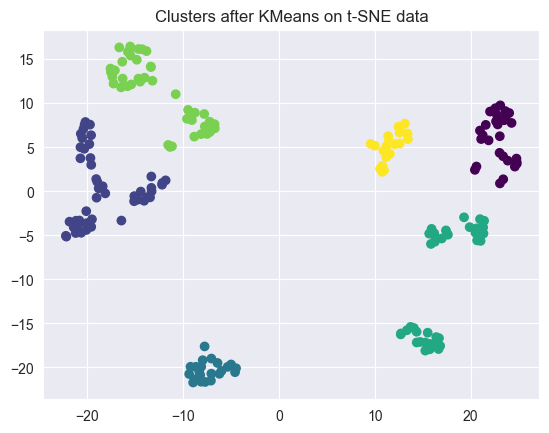

В клaстере '0' количество 29
'Genre' мин: 1 макс: 1
'Age' мин: 35 макс: 70
'Annual Income (k$)' мин: 19 макс: 63
'Spending Score (1-100)' мин: 3 макс: 60

В клaстере '1' количество 47
'Genre' мин: 0 макс: 0
'Age' мин: 18 макс: 58
'Annual Income (k$)' мин: 16 макс: 76
'Spending Score (1-100)' мин: 5 макс: 99

В клaстере '2' количество 22
'Genre' мин: 0 макс: 0
'Age' мин: 27 макс: 40
'Annual Income (k$)' мин: 69 макс: 120
'Spending Score (1-100)' мин: 58 макс: 95

В клaстере '3' количество 39
'Genre' мин: 1 макс: 1
'Age' мин: 18 макс: 40
'Annual Income (k$)' мин: 15 макс: 137
'Spending Score (1-100)' мин: 39 макс: 97

В клaстере '4' количество 43
'Genre' мин: 0 макс: 0
'Age' мин: 34 макс: 68
'Annual Income (k$)' мин: 38 макс: 126
'Spending Score (1-100)' мин: 5 макс: 59

В клaстере '5' количество 20
'Genre' мин: 1 макс: 1
'Age' мин: 19 макс: 59
'Annual Income (k$)' мин: 71 макс: 137
'Spending Score (1-100)' мин: 1 макс: 36



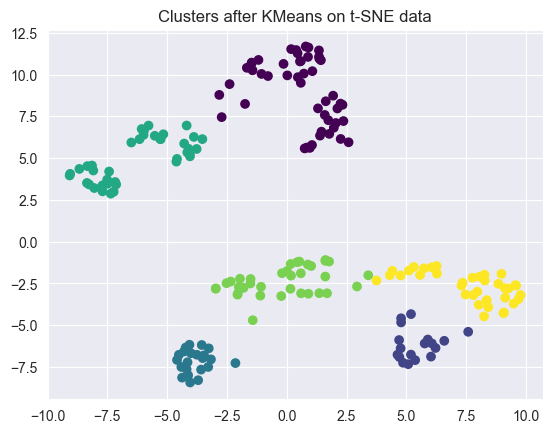

В клaстере '0' количество 49
'Genre' мин: 1 макс: 1
'Age' мин: 19 макс: 70
'Annual Income (k$)' мин: 19 макс: 137
'Spending Score (1-100)' мин: 1 макс: 60

В клaстере '1' количество 18
'Genre' мин: 0 макс: 0
'Age' мин: 34 макс: 57
'Annual Income (k$)' мин: 60 макс: 126
'Spending Score (1-100)' мин: 5 макс: 42

В клaстере '2' количество 22
'Genre' мин: 0 макс: 0
'Age' мин: 27 макс: 40
'Annual Income (k$)' мин: 69 макс: 120
'Spending Score (1-100)' мин: 58 макс: 95

В клaстере '3' количество 39
'Genre' мин: 1 макс: 1
'Age' мин: 18 макс: 40
'Annual Income (k$)' мин: 15 макс: 137
'Spending Score (1-100)' мин: 39 макс: 97

В клaстере '4' количество 36
'Genre' мин: 0 макс: 0
'Age' мин: 18 макс: 35
'Annual Income (k$)' мин: 16 макс: 76
'Spending Score (1-100)' мин: 6 макс: 99

В клaстере '5' количество 36
'Genre' мин: 0 макс: 0
'Age' мин: 35 макс: 68
'Annual Income (k$)' мин: 18 макс: 67
'Spending Score (1-100)' мин: 5 макс: 59



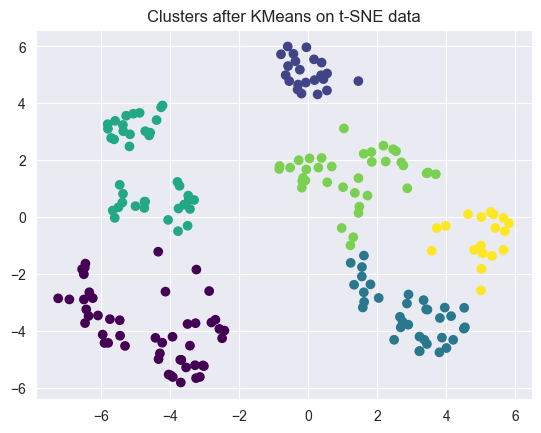

В клaстере '0' количество 49
'Genre' мин: 1 макс: 1
'Age' мин: 19 макс: 70
'Annual Income (k$)' мин: 19 макс: 137
'Spending Score (1-100)' мин: 1 макс: 60

В клaстере '1' количество 22
'Genre' мин: 0 макс: 0
'Age' мин: 27 макс: 40
'Annual Income (k$)' мин: 69 макс: 120
'Spending Score (1-100)' мин: 58 макс: 95

В клaстере '2' количество 35
'Genre' мин: 0 макс: 0
'Age' мин: 35 макс: 68
'Annual Income (k$)' мин: 18 макс: 67
'Spending Score (1-100)' мин: 5 макс: 59

В клaстере '3' количество 39
'Genre' мин: 1 макс: 1
'Age' мин: 18 макс: 40
'Annual Income (k$)' мин: 15 макс: 137
'Spending Score (1-100)' мин: 39 макс: 97

В клaстере '4' количество 37
'Genre' мин: 0 макс: 0
'Age' мин: 18 макс: 35
'Annual Income (k$)' мин: 16 макс: 76
'Spending Score (1-100)' мин: 6 макс: 99

В клaстере '5' количество 18
'Genre' мин: 0 макс: 0
'Age' мин: 34 макс: 57
'Annual Income (k$)' мин: 60 макс: 126
'Spending Score (1-100)' мин: 5 макс: 42



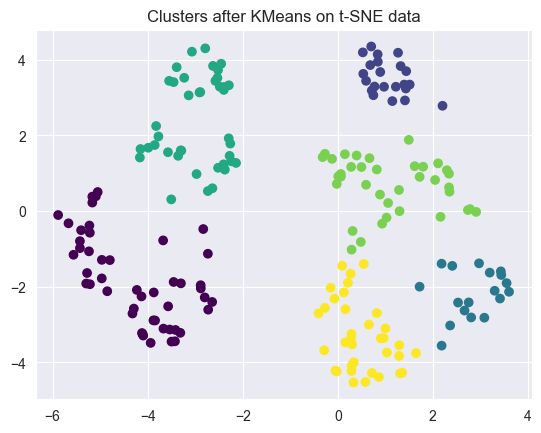

В клaстере '0' количество 48
'Genre' мин: 1 макс: 1
'Age' мин: 19 макс: 70
'Annual Income (k$)' мин: 19 макс: 137
'Spending Score (1-100)' мин: 1 макс: 60

В клaстере '1' количество 22
'Genre' мин: 0 макс: 0
'Age' мин: 27 макс: 40
'Annual Income (k$)' мин: 69 макс: 120
'Spending Score (1-100)' мин: 58 макс: 95

В клaстере '2' количество 18
'Genre' мин: 0 макс: 0
'Age' мин: 34 макс: 57
'Annual Income (k$)' мин: 60 макс: 126
'Spending Score (1-100)' мин: 5 макс: 42

В клaстере '3' количество 40
'Genre' мин: 1 макс: 1
'Age' мин: 18 макс: 40
'Annual Income (k$)' мин: 15 макс: 137
'Spending Score (1-100)' мин: 39 макс: 97

В клaстере '4' количество 37
'Genre' мин: 0 макс: 0
'Age' мин: 18 макс: 35
'Annual Income (k$)' мин: 16 макс: 76
'Spending Score (1-100)' мин: 6 макс: 99

В клaстере '5' количество 35
'Genre' мин: 0 макс: 0
'Age' мин: 35 макс: 68
'Annual Income (k$)' мин: 18 макс: 67
'Spending Score (1-100)' мин: 5 макс: 59



In [722]:
from sklearn.manifold import TSNE

for p_perplexity in range(15, 85,20):
    tsne = TSNE(n_components=2, perplexity=p_perplexity, random_state=0) 
    X_embedded = tsne.fit_transform(df_iterate)
    kmeans = KMeans(n_clusters=num_of_cluster, random_state=0)
    clusters = kmeans.fit_predict(X_embedded) 
    df_cluster['cluster'] = clusters
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=clusters, cmap='viridis')
    plt.title("Clusters after KMeans on t-SNE data")
    plt.show()
    min_max_scaler_upgrade(df_cluster)

Данные были скопированы в excel для более удобного просмотра различий пяти примеров

Видно, что при значении "perplexity" 15 при последующих значений кластеризации по разбиению не различаются 

Данные в основном распределились по полу, в пользу женского 

### Кластеризатор SpectralClustering


Почему был выбран? Из картинки с примерами результата - он был крут с тяжелыми группировками и единственный без шумов  

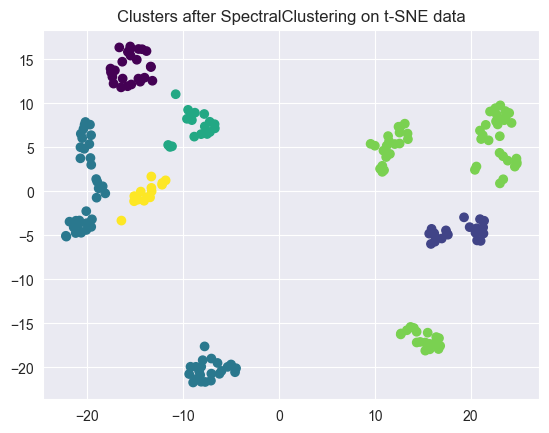

В клaстере '0' количество 25
'Genre' мин: 0 макс: 0
'Age' мин: 43 макс: 68
'Annual Income (k$)' мин: 38 макс: 67
'Spending Score (1-100)' мин: 35 макс: 59

В клaстере '1' количество 21
'Genre' мин: 1 макс: 1
'Age' мин: 18 макс: 35
'Annual Income (k$)' мин: 15 макс: 67
'Spending Score (1-100)' мин: 39 макс: 92

В клaстере '2' количество 55
'Genre' мин: 0 макс: 0
'Age' мин: 20 макс: 58
'Annual Income (k$)' мин: 16 макс: 120
'Spending Score (1-100)' мин: 5 макс: 99

В клaстере '3' количество 18
'Genre' мин: 0 макс: 0
'Age' мин: 34 макс: 57
'Annual Income (k$)' мин: 60 макс: 126
'Spending Score (1-100)' мин: 5 макс: 42

В клaстере '4' количество 67
'Genre' мин: 1 макс: 1
'Age' мин: 19 макс: 70
'Annual Income (k$)' мин: 19 макс: 137
'Spending Score (1-100)' мин: 1 макс: 97

В клaстере '5' количество 14
'Genre' мин: 0 макс: 0
'Age' мин: 18 макс: 34
'Annual Income (k$)' мин: 54 макс: 76
'Spending Score (1-100)' мин: 29 макс: 60



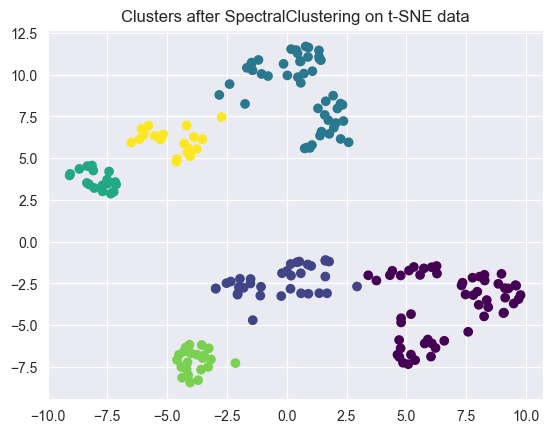

В клaстере '0' количество 55
'Genre' мин: 0 макс: 0
'Age' мин: 20 макс: 68
'Annual Income (k$)' мин: 16 макс: 126
'Spending Score (1-100)' мин: 5 макс: 59

В клaстере '1' количество 35
'Genre' мин: 0 макс: 0
'Age' мин: 18 макс: 35
'Annual Income (k$)' мин: 16 макс: 76
'Spending Score (1-100)' мин: 29 макс: 99

В клaстере '2' количество 48
'Genre' мин: 1 макс: 1
'Age' мин: 19 макс: 70
'Annual Income (k$)' мин: 19 макс: 137
'Spending Score (1-100)' мин: 1 макс: 60

В клaстере '3' количество 18
'Genre' мин: 1 макс: 1
'Age' мин: 27 макс: 40
'Annual Income (k$)' мин: 69 макс: 137
'Spending Score (1-100)' мин: 63 макс: 97

В клaстере '4' количество 22
'Genre' мин: 0 макс: 0
'Age' мин: 27 макс: 40
'Annual Income (k$)' мин: 69 макс: 120
'Spending Score (1-100)' мин: 58 макс: 95

В клaстере '5' количество 22
'Genre' мин: 1 макс: 1
'Age' мин: 18 макс: 38
'Annual Income (k$)' мин: 15 макс: 67
'Spending Score (1-100)' мин: 39 макс: 92



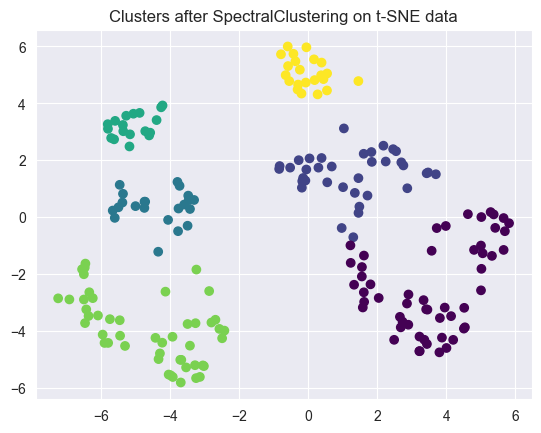

В клaстере '0' количество 54
'Genre' мин: 0 макс: 0
'Age' мин: 34 макс: 68
'Annual Income (k$)' мин: 18 макс: 126
'Spending Score (1-100)' мин: 5 макс: 59

В клaстере '1' количество 36
'Genre' мин: 0 макс: 0
'Age' мин: 18 макс: 35
'Annual Income (k$)' мин: 16 макс: 76
'Spending Score (1-100)' мин: 6 макс: 99

В клaстере '2' количество 22
'Genre' мин: 1 макс: 1
'Age' мин: 18 макс: 38
'Annual Income (k$)' мин: 15 макс: 67
'Spending Score (1-100)' мин: 39 макс: 92

В клaстере '3' количество 18
'Genre' мин: 1 макс: 1
'Age' мин: 27 макс: 40
'Annual Income (k$)' мин: 69 макс: 137
'Spending Score (1-100)' мин: 63 макс: 97

В клaстере '4' количество 48
'Genre' мин: 1 макс: 1
'Age' мин: 19 макс: 70
'Annual Income (k$)' мин: 19 макс: 137
'Spending Score (1-100)' мин: 1 макс: 60

В клaстере '5' количество 22
'Genre' мин: 0 макс: 0
'Age' мин: 27 макс: 40
'Annual Income (k$)' мин: 69 макс: 120
'Spending Score (1-100)' мин: 58 макс: 95



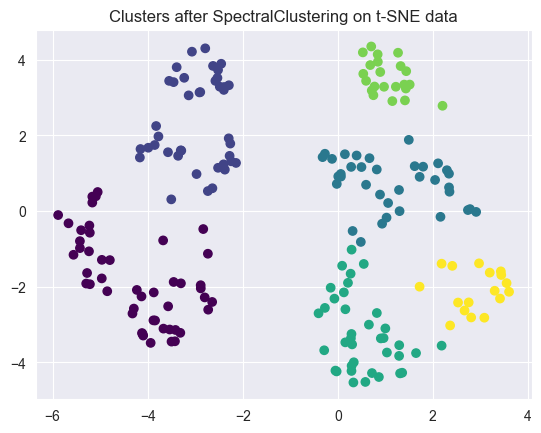

В клaстере '0' количество 48
'Genre' мин: 1 макс: 1
'Age' мин: 19 макс: 70
'Annual Income (k$)' мин: 19 макс: 137
'Spending Score (1-100)' мин: 1 макс: 60

В клaстере '1' количество 40
'Genre' мин: 1 макс: 1
'Age' мин: 18 макс: 40
'Annual Income (k$)' мин: 15 макс: 137
'Spending Score (1-100)' мин: 39 макс: 97

В клaстере '2' количество 36
'Genre' мин: 0 макс: 0
'Age' мин: 18 макс: 35
'Annual Income (k$)' мин: 16 макс: 76
'Spending Score (1-100)' мин: 6 макс: 99

В клaстере '3' количество 37
'Genre' мин: 0 макс: 0
'Age' мин: 35 макс: 68
'Annual Income (k$)' мин: 18 макс: 79
'Spending Score (1-100)' мин: 5 макс: 59

В клaстере '4' количество 22
'Genre' мин: 0 макс: 0
'Age' мин: 27 макс: 40
'Annual Income (k$)' мин: 69 макс: 120
'Spending Score (1-100)' мин: 58 макс: 95

В клaстере '5' количество 17
'Genre' мин: 0 макс: 0
'Age' мин: 34 макс: 57
'Annual Income (k$)' мин: 60 макс: 126
'Spending Score (1-100)' мин: 5 макс: 42



In [730]:
from sklearn.cluster import SpectralClustering

for p_perplexity in range(15, 85 ,20):
    tsne = TSNE(n_components=2, perplexity=p_perplexity, random_state=0) 
    X_embedded = tsne.fit_transform(df_iterate)
    
    
    sc = SpectralClustering(n_clusters=num_of_cluster, random_state=0)
    clusters = sc.fit_predict(X_embedded)
    df_cluster['cluster'] = clusters
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=clusters, cmap='viridis')
    plt.title("Clusters after SpectralClustering on t-SNE data")
    plt.show()

    min_max_scaler_upgrade(df_cluster)

Наблюдаем, что при маленьком значении данные отличаются от последующих, кластаризация получилась такая же, как в предыдущем варианте

### Великий и ужасный волш... DBSCAN

Получим цвета для функции и исключим одноцветные светлые и темные

In [682]:
import matplotlib.colors as mcolors
colors = list(mcolors.CSS4_COLORS.keys())
for color in colors:
    for delette in ["black","white","light","dark","dim"]:
        if delette in color.lower():
            colors.remove(color)
            continue

#### Начинаем искать параметры для dbscan

Ищем полу-автоматическое нахождение параметров в интернете и начинаем! [Работа откуда взят код](https://www.kaggle.com/code/tanmaymane18/nearestneighbors-to-find-optimal-eps-in-dbscan) 

В нем применяются растояния "NearestNeighbors" и метод "Силуэта" для нахождения лучших результатов

Он был переписан - автоматизирован и переделан в функцию

In [732]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
def get_eps_min_samples_for_dbscan(X):
    """
    Функция находит лучшие параметры для dbscan 
    :param X: Визуализированные данные
    :return: min_samples, eps, score 
    """
    nn = NearestNeighbors(n_neighbors=20).fit(X)
    distances, indices = nn.kneighbors(X)
    distances = np.sort(distances, axis=0)[:,1]
    
    small_distances = distances[len(distances) - len(distances) // 6:] # Я сократил данные для автоматизации  

    min_distance = round(small_distances[0],2)
    max_value = round(small_distances[-1],2)
    
    output = []
    
    for ms in range(1,21):
        for ep in np.arange(min_distance,max_value, 0.01):
            try:
                labels = DBSCAN(eps=ep, min_samples=ms).fit_predict(X)
                score = silhouette_score(X, labels)
                output.append((ms, ep, score))
            except:
                continue
    return sorted(output, key=lambda x:x[-1])[-1]

Функция, которая показывает график с кластерами

In [734]:
def show_clusters(X, cluster):
    from pandas import DataFrame
    df = DataFrame(dict (x=X[:,0], y=X[:,1], label=cluster))
    fig, ax = plt.subplots(figsize=(8, 8))
    grouped = df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter' , x='x', y='y', label=key, color=colors[key])
    plt.xlabel ('X_1')
    plt.ylabel ('X_2')
    plt.show()

#### Кластеризуем 1 

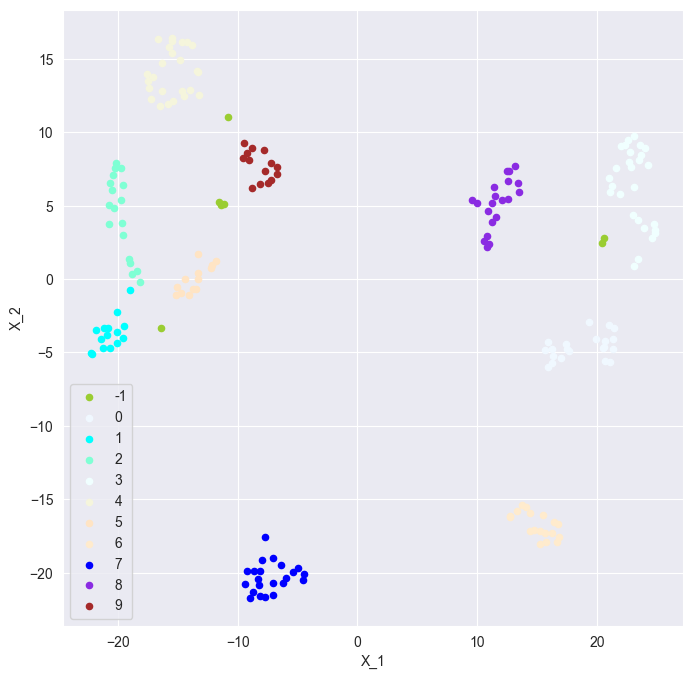

В клaстере '-1' количество 7
'Genre' мин: 0 макс: 1
'Age' мин: 34 макс: 56
'Annual Income (k$)' мин: 54 макс: 79
'Spending Score (1-100)' мин: 35 макс: 60

В клaстере '0' количество 21
'Genre' мин: 1 макс: 1
'Age' мин: 18 макс: 35
'Annual Income (k$)' мин: 15 макс: 67
'Spending Score (1-100)' мин: 39 макс: 92

В клaстере '1' количество 15
'Genre' мин: 0 макс: 0
'Age' мин: 20 макс: 35
'Annual Income (k$)' мин: 16 макс: 43
'Spending Score (1-100)' мин: 54 макс: 99

В клaстере '2' количество 18
'Genre' мин: 0 макс: 0
'Age' мин: 20 макс: 58
'Annual Income (k$)' мин: 16 макс: 48
'Spending Score (1-100)' мин: 5 макс: 51

В клaстере '3' количество 27
'Genre' мин: 1 макс: 1
'Age' мин: 35 макс: 70
'Annual Income (k$)' мин: 19 макс: 63
'Spending Score (1-100)' мин: 3 макс: 60

В клaстере '4' количество 25
'Genre' мин: 0 макс: 0
'Age' мин: 43 макс: 68
'Annual Income (k$)' мин: 38 макс: 67
'Spending Score (1-100)' мин: 35 макс: 59

В клaстере '5' количество 13
'Genre' мин: 0 макс: 0
'Age' мин: 18 

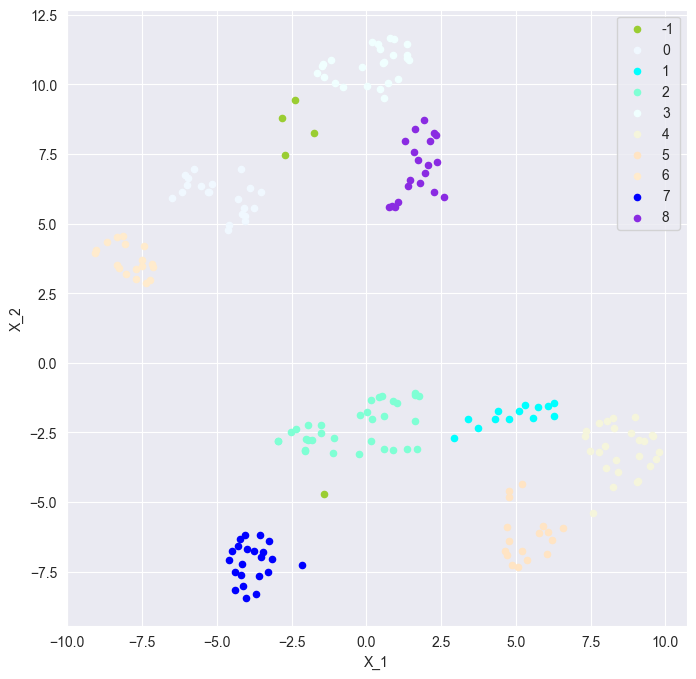

В клaстере '-1' количество 5
'Genre' мин: 0 макс: 1
'Age' мин: 34 макс: 40
'Annual Income (k$)' мин: 20 макс: 58
'Spending Score (1-100)' мин: 13 макс: 60

В клaстере '0' количество 21
'Genre' мин: 1 макс: 1
'Age' мин: 18 макс: 35
'Annual Income (k$)' мин: 15 макс: 67
'Spending Score (1-100)' мин: 39 макс: 92

В клaстере '1' количество 13
'Genre' мин: 0 макс: 0
'Age' мин: 20 макс: 58
'Annual Income (k$)' мин: 16 макс: 39
'Spending Score (1-100)' мин: 5 макс: 40

В клaстере '2' количество 33
'Genre' мин: 0 макс: 0
'Age' мин: 18 макс: 35
'Annual Income (k$)' мин: 16 макс: 76
'Spending Score (1-100)' мин: 29 макс: 99

В клaстере '3' количество 25
'Genre' мин: 1 макс: 1
'Age' мин: 47 макс: 70
'Annual Income (k$)' мин: 19 макс: 63
'Spending Score (1-100)' мин: 3 макс: 60

В клaстере '4' количество 26
'Genre' мин: 0 макс: 0
'Age' мин: 43 макс: 68
'Annual Income (k$)' мин: 38 макс: 79
'Spending Score (1-100)' мин: 35 макс: 59

В клaстере '5' количество 17
'Genre' мин: 0 макс: 0
'Age' мин: 34 

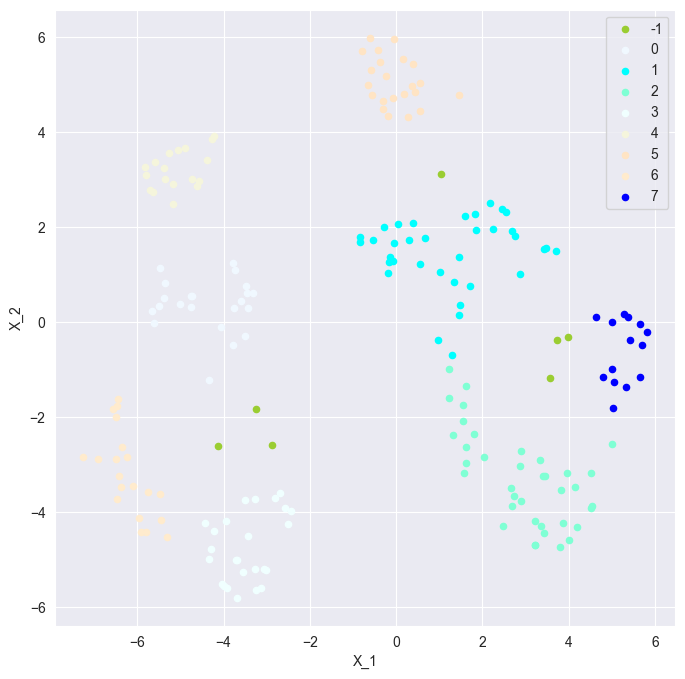

В клaстере '-1' количество 7
'Genre' мин: 0 макс: 1
'Age' мин: 34 макс: 40
'Annual Income (k$)' мин: 20 макс: 67
'Spending Score (1-100)' мин: 13 макс: 60

В клaстере '0' количество 22
'Genre' мин: 1 макс: 1
'Age' мин: 18 макс: 38
'Annual Income (k$)' мин: 15 макс: 67
'Spending Score (1-100)' мин: 39 макс: 92

В клaстере '1' количество 35
'Genre' мин: 0 макс: 0
'Age' мин: 18 макс: 35
'Annual Income (k$)' мин: 16 макс: 76
'Spending Score (1-100)' мин: 6 макс: 99

В клaстере '2' количество 37
'Genre' мин: 0 макс: 0
'Age' мин: 35 макс: 68
'Annual Income (k$)' мин: 18 макс: 79
'Spending Score (1-100)' мин: 5 макс: 59

В клaстере '3' количество 25
'Genre' мин: 1 макс: 1
'Age' мин: 47 макс: 70
'Annual Income (k$)' мин: 19 макс: 63
'Spending Score (1-100)' мин: 3 макс: 60

В клaстере '4' количество 18
'Genre' мин: 1 макс: 1
'Age' мин: 27 макс: 40
'Annual Income (k$)' мин: 69 макс: 137
'Spending Score (1-100)' мин: 63 макс: 97

В клaстере '5' количество 22
'Genre' мин: 0 макс: 0
'Age' мин: 27 

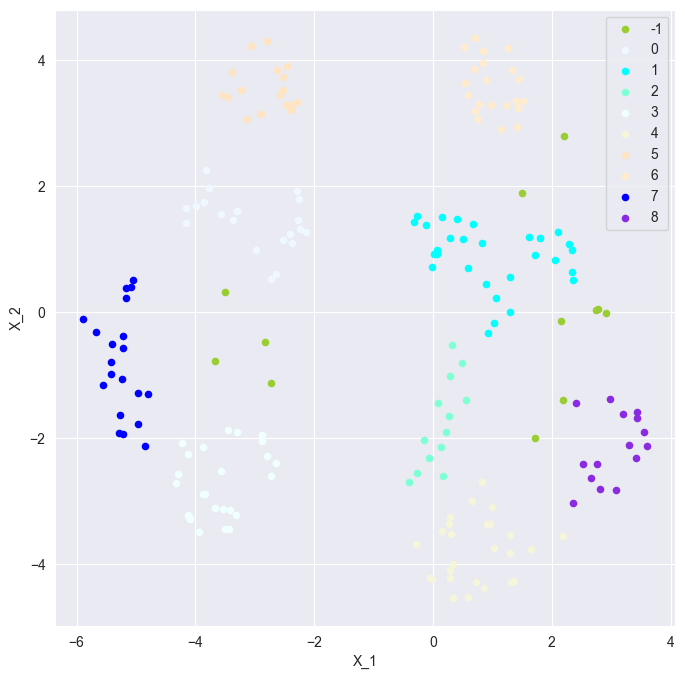

В клaстере '-1' количество 12
'Genre' мин: 0 макс: 1
'Age' мин: 23 макс: 40
'Annual Income (k$)' мин: 20 макс: 76
'Spending Score (1-100)' мин: 13 макс: 60

В клaстере '0' количество 21
'Genre' мин: 1 макс: 1
'Age' мин: 18 макс: 35
'Annual Income (k$)' мин: 15 макс: 67
'Spending Score (1-100)' мин: 39 макс: 92

В клaстере '1' количество 29
'Genre' мин: 0 макс: 0
'Age' мин: 18 макс: 35
'Annual Income (k$)' мин: 16 макс: 65
'Spending Score (1-100)' мин: 41 макс: 99

В клaстере '2' количество 13
'Genre' мин: 0 макс: 0
'Age' мин: 20 макс: 58
'Annual Income (k$)' мин: 16 макс: 39
'Spending Score (1-100)' мин: 5 макс: 40

В клaстере '3' количество 25
'Genre' мин: 1 макс: 1
'Age' мин: 47 макс: 70
'Annual Income (k$)' мин: 19 макс: 63
'Spending Score (1-100)' мин: 3 макс: 60

В клaстере '4' количество 26
'Genre' мин: 0 макс: 0
'Age' мин: 43 макс: 68
'Annual Income (k$)' мин: 38 макс: 79
'Spending Score (1-100)' мин: 35 макс: 59

В клaстере '5' количество 18
'Genre' мин: 1 макс: 1
'Age' мин: 27

In [819]:
from sklearn.cluster import DBSCAN

for p_perplexity in range(15, 85 ,20):
    tsne = TSNE(n_components=2, perplexity=p_perplexity, random_state=0) 
    X_embedded = tsne.fit_transform(df_iterate)
    min_samples, eps, score = get_eps_min_samples_for_dbscan(X_embedded)    
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X_embedded)
    cluster = clustering.labels_
    show_clusters(X_embedded, cluster)
    df_cluster['cluster'] = cluster
    min_max_scaler_upgrade(df_cluster)

буду сравнивать то, где кластеров одинаково, в первом варианте при значении 35 мы наблюдаем меньше значений в шуме чем при "perplexity" 85, остальные кластеры очень близки к значениям друг друга - разбиение одинаково

#### Кластеризация 2

Попробуем вручную поставить значения, для достижения 6 кластеров, для сравнения с остальными кластеризаторами

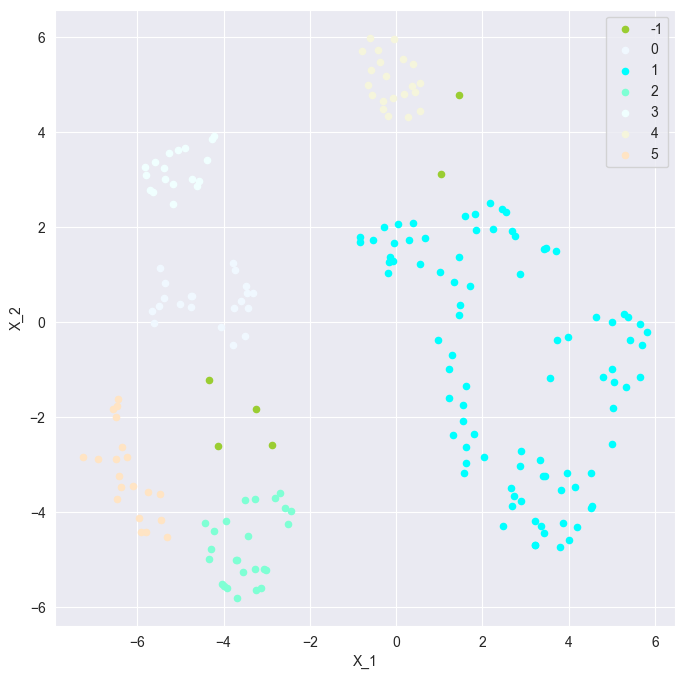

В клaстере '-1' количество 6
'Genre' мин: 0 макс: 1
'Age' мин: 34 макс: 40
'Annual Income (k$)' мин: 20 макс: 69
'Spending Score (1-100)' мин: 13 макс: 60

В клaстере '0' количество 21
'Genre' мин: 1 макс: 1
'Age' мин: 18 макс: 35
'Annual Income (k$)' мин: 15 макс: 67
'Spending Score (1-100)' мин: 39 макс: 92

В клaстере '1' количество 89
'Genre' мин: 0 макс: 0
'Age' мин: 18 макс: 68
'Annual Income (k$)' мин: 16 макс: 126
'Spending Score (1-100)' мин: 5 макс: 99

В клaстере '2' количество 25
'Genre' мин: 1 макс: 1
'Age' мин: 47 макс: 70
'Annual Income (k$)' мин: 19 макс: 63
'Spending Score (1-100)' мин: 3 макс: 60

В клaстере '3' количество 18
'Genre' мин: 1 макс: 1
'Age' мин: 27 макс: 40
'Annual Income (k$)' мин: 69 макс: 137
'Spending Score (1-100)' мин: 63 макс: 97

В клaстере '4' количество 21
'Genre' мин: 0 макс: 0
'Age' мин: 27 макс: 38
'Annual Income (k$)' мин: 70 макс: 120
'Spending Score (1-100)' мин: 69 макс: 95

В клaстере '5' количество 20
'Genre' мин: 1 макс: 1
'Age' мин: 

In [847]:
tsne = TSNE(n_components=2, perplexity=55, random_state=0) 
X_embedded = tsne.fit_transform(df_iterate)
min_samples, eps, score = get_eps_min_samples_for_dbscan(X_embedded)    
clustering = DBSCAN(eps=0.88, min_samples=3).fit(X_embedded)
cluster = clustering.labels_
show_clusters(X_embedded, cluster)
df_cluster['cluster'] = cluster
min_max_scaler_upgrade(df_cluster)

Видим существенную разницу с построением кластеров, разделение произошло в пользу мужского пола и отправила большую часть женского пола в одну группу. 

## Кластеризация c PCA

Будем сохранять все данные для визуализации и автоматические режимы - это всё используются по умолчанию

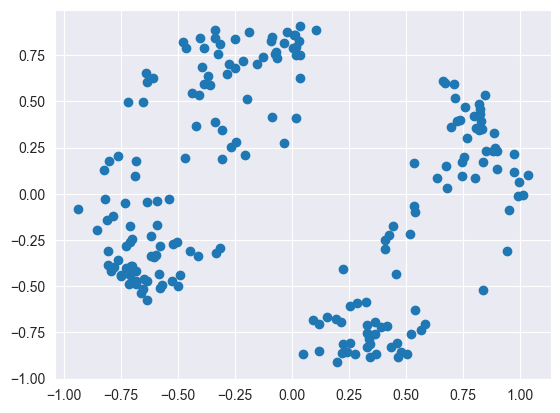

In [854]:
from sklearn.decomposition import PCA
pca = PCA()
X_embedded = pca.fit_transform(df_iterate)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
plt.show()

### KMeans

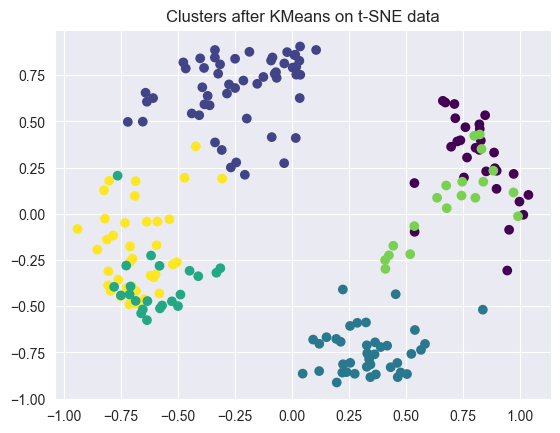

В клaстере '0' количество 29
'Genre' мин: 1 макс: 1
'Age' мин: 35 макс: 70
'Annual Income (k$)' мин: 19 макс: 71
'Spending Score (1-100)' мин: 3 макс: 60

В клaстере '1' количество 53
'Genre' мин: 0 макс: 0
'Age' мин: 34 макс: 68
'Annual Income (k$)' мин: 18 макс: 126
'Spending Score (1-100)' мин: 5 макс: 59

В клaстере '2' количество 40
'Genre' мин: 1 макс: 1
'Age' мин: 18 макс: 40
'Annual Income (k$)' мин: 15 макс: 137
'Spending Score (1-100)' мин: 39 макс: 97

В клaстере '3' количество 22
'Genre' мин: 0 макс: 0
'Age' мин: 27 макс: 40
'Annual Income (k$)' мин: 69 макс: 120
'Spending Score (1-100)' мин: 58 макс: 95

В клaстере '4' количество 19
'Genre' мин: 1 макс: 1
'Age' мин: 19 макс: 59
'Annual Income (k$)' мин: 71 макс: 137
'Spending Score (1-100)' мин: 1 макс: 36

В клaстере '5' количество 37
'Genre' мин: 0 макс: 0
'Age' мин: 18 макс: 35
'Annual Income (k$)' мин: 16 макс: 76
'Spending Score (1-100)' мин: 6 макс: 99



In [748]:
kmeans = KMeans(n_clusters=num_of_cluster, random_state=0)
clusters = kmeans.fit_predict(X_embedded) 
df_cluster['cluster'] = clusters
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=clusters, cmap='viridis')
plt.title("Clusters after KMeans on PCA data")
plt.show()
min_max_scaler_upgrade(df_cluster)

Данные получились разделенны по полу на 3 кластера в каждом, по другому чем в tsne

### Spectral Clustering

Поиграемся с подбором параметров, чтобы не было ошибки

Поэтому используем алгоритм kmeans  

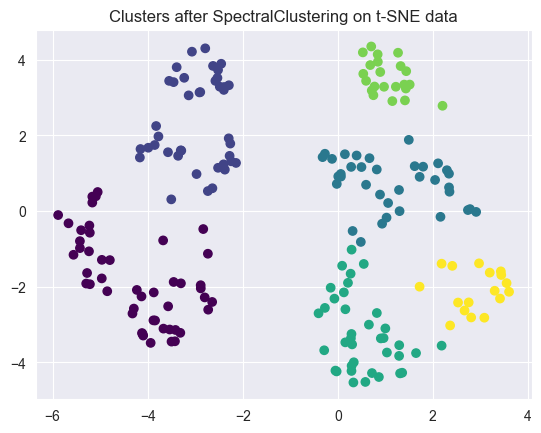

В клaстере '0' количество 48
'Genre' мин: 1 макс: 1
'Age' мин: 19 макс: 70
'Annual Income (k$)' мин: 19 макс: 137
'Spending Score (1-100)' мин: 1 макс: 60

В клaстере '1' количество 40
'Genre' мин: 1 макс: 1
'Age' мин: 18 макс: 40
'Annual Income (k$)' мин: 15 макс: 137
'Spending Score (1-100)' мин: 39 макс: 97

В клaстере '2' количество 36
'Genre' мин: 0 макс: 0
'Age' мин: 18 макс: 35
'Annual Income (k$)' мин: 16 макс: 76
'Spending Score (1-100)' мин: 6 макс: 99

В клaстере '3' количество 37
'Genre' мин: 0 макс: 0
'Age' мин: 35 макс: 68
'Annual Income (k$)' мин: 18 макс: 79
'Spending Score (1-100)' мин: 5 макс: 59

В клaстере '4' количество 22
'Genre' мин: 0 макс: 0
'Age' мин: 27 макс: 40
'Annual Income (k$)' мин: 69 макс: 120
'Spending Score (1-100)' мин: 58 макс: 95

В клaстере '5' количество 17
'Genre' мин: 0 макс: 0
'Age' мин: 34 макс: 57
'Annual Income (k$)' мин: 60 макс: 126
'Spending Score (1-100)' мин: 5 макс: 42



In [780]:
sc = SpectralClustering(n_clusters = num_of_cluster, random_state = 0)
clusters = sc.fit_predict(X_embedded)
df_cluster['cluster'] = clusters
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c = clusters, cmap = 'viridis')
plt.title("Clusters after SpectralClustering on PCA data")
plt.show()

min_max_scaler_upgrade(df_cluster)

Можно заметить, что разбиение по кластерам не изменилось с их аналогом на "t-SNE"

### DBSCAN

В этот раз, сначала, подберем параметры для 6 кластеров


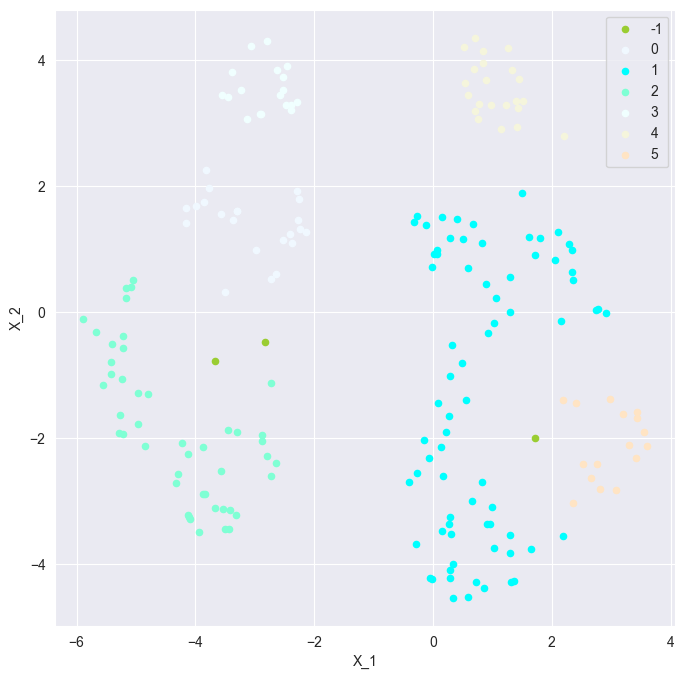

В клaстере '-1' количество 3
'Genre' мин: 0 макс: 1
'Age' мин: 35 макс: 40
'Annual Income (k$)' мин: 24 макс: 60
'Spending Score (1-100)' мин: 35 макс: 48

В клaстере '0' количество 22
'Genre' мин: 1 макс: 1
'Age' мин: 18 макс: 38
'Annual Income (k$)' мин: 15 макс: 67
'Spending Score (1-100)' мин: 39 макс: 92

В клaстере '1' количество 73
'Genre' мин: 0 макс: 0
'Age' мин: 18 макс: 68
'Annual Income (k$)' мин: 16 макс: 79
'Spending Score (1-100)' мин: 5 макс: 99

В клaстере '2' количество 46
'Genre' мин: 1 макс: 1
'Age' мин: 19 макс: 70
'Annual Income (k$)' мин: 19 макс: 137
'Spending Score (1-100)' мин: 1 макс: 60

В клaстере '3' количество 18
'Genre' мин: 1 макс: 1
'Age' мин: 27 макс: 40
'Annual Income (k$)' мин: 69 макс: 137
'Spending Score (1-100)' мин: 63 макс: 97

В клaстере '4' количество 22
'Genre' мин: 0 макс: 0
'Age' мин: 27 макс: 40
'Annual Income (k$)' мин: 69 макс: 120
'Spending Score (1-100)' мин: 58 макс: 95

В клaстере '5' количество 16
'Genre' мин: 0 макс: 0
'Age' мин: 

In [823]:
clustering = DBSCAN(eps=0.88, min_samples=8).fit(X_embedded)
cluster = clustering.labels_
show_clusters(X_embedded, cluster)
df_cluster['cluster'] = cluster
min_max_scaler_upgrade(df_cluster)

Расперделение получается "кривым", по сравнению свыше использованными классторизаторами, один из кластеров становится довольно большим по сравнению с остальными в группе.  

А теперь автоматическую

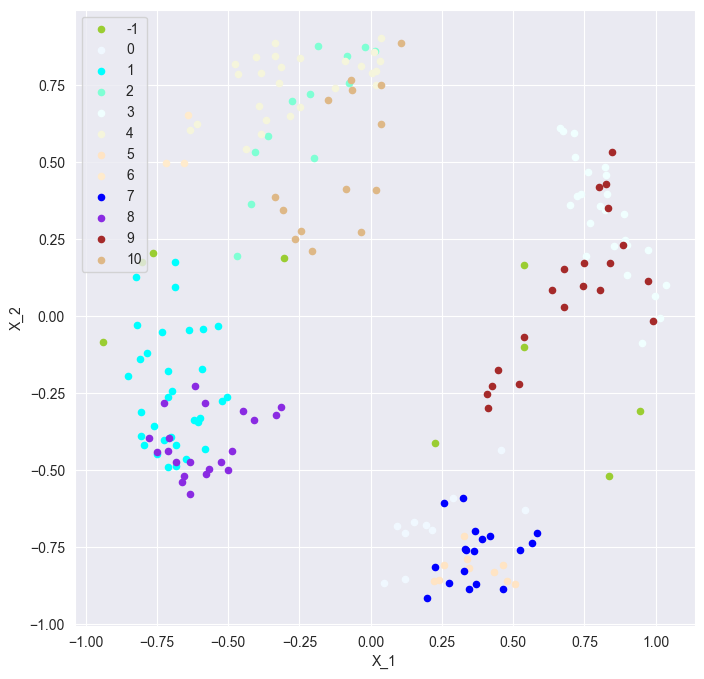

В клaстере '-1' количество 9
'Genre' мин: 0 макс: 1
'Age' мин: 19 макс: 40
'Annual Income (k$)' мин: 15 макс: 69
'Spending Score (1-100)' мин: 6 макс: 60

В клaстере '0' количество 10
'Genre' мин: 1 макс: 1
'Age' мин: 18 макс: 35
'Annual Income (k$)' мин: 15 макс: 42
'Spending Score (1-100)' мин: 60 макс: 92

В клaстере '1' количество 32
'Genre' мин: 0 макс: 0
'Age' мин: 18 макс: 35
'Annual Income (k$)' мин: 16 макс: 76
'Spending Score (1-100)' мин: 29 макс: 99

В клaстере '2' количество 12
'Genre' мин: 0 макс: 0
'Age' мин: 31 макс: 58
'Annual Income (k$)' мин: 17 макс: 39
'Spending Score (1-100)' мин: 5 макс: 40

В клaстере '3' количество 25
'Genre' мин: 1 макс: 1
'Age' мин: 47 макс: 70
'Annual Income (k$)' мин: 19 макс: 63
'Spending Score (1-100)' мин: 3 макс: 60

В клaстере '4' количество 26
'Genre' мин: 0 макс: 0
'Age' мин: 43 макс: 68
'Annual Income (k$)' мин: 38 макс: 79
'Spending Score (1-100)' мин: 35 макс: 59

В клaстере '5' количество 10
'Genre' мин: 1 макс: 1
'Age' мин: 18 м

In [857]:
min_samples, eps, score = get_eps_min_samples_for_dbscan(X_embedded)   

clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X_embedded)
cluster = clustering.labels_
show_clusters(X_embedded, cluster)
df_cluster['cluster'] = cluster
min_max_scaler_upgrade(df_cluster)

Сравнению не подлежит - много кластеров, можно сказать, что кластер из 3 людей женского пола делать было не обязательно

По итогу можно сказать, что автоматическое нахождение параметров - ужасно, если нужно определенное количество кластеров, но если нет, тогда удобно - сразу получается разбиение и минимальное кол-во шума, что для dbscan задача веселая